In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2162397883866225800
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10081009664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4880696619109420268
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


**Importing the necessary packages**

In [29]:
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import load_model



from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

**Reading the image files**

In [3]:

dire= 'F:\\Ml files\\Weed detection\\flower recognition\\data'
categories=['dandelion', 'daisy', 'sunflowers', 'tulips', 'roses', 'Buttercup']


In [4]:
features=[]
for i in categories:
    path=os.path.join(dire,i)
    num_classes=categories.index(i)
    for img in os.listdir(path):
        if img.endswith('.jpg'): 
            img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            img_array=cv2.resize(img_array,(150,150))
            features.append([img_array,num_classes])

In [5]:
X=[]
y=[]
for i,j in features:
    X.append(i)
    y.append(j)

**Example of flower images per class**

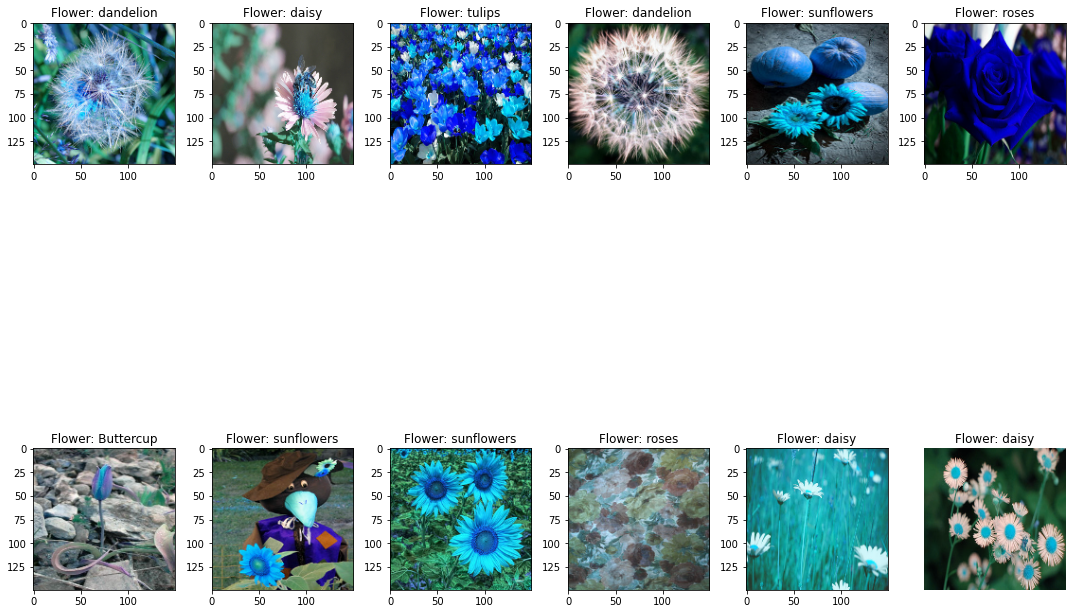

In [6]:
fig,ax=plt.subplots(2,6)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (6):
        l=np.random.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+categories[y[l]])
plt.axis('off')        
plt.tight_layout()

Reshaping and normalizing: the need of resizing the feature vetcor x is to meet the keras requirement and normalization is done to scale all the values in a similar range¶


In [7]:
X=np.array(X).reshape(-1,150,150,3)/255.0

**Class destribution**

C:\Users\Ovi\anaconda3\envs\tensrgpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


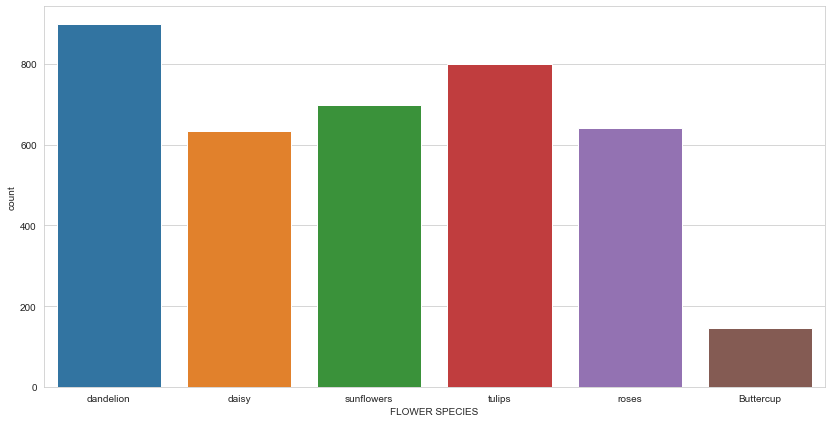

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,7))
fig=sns.countplot(y)
fig.set(xticks=range(len(categories)), xticklabels=[i for i in categories])
plt.xlabel('FLOWER SPECIES')
plt.show()

In [9]:
list_dandelion=len([i for i in y if i==0])
list_daisy=len([i for i in y if i==1])
list_sunflower=len([i for i in y if i==2])
list_tulip=len([ i for i in y if i==3])
list_rose=len([i for i in y if i==4])
list_buttercup = len([i for i in y if i==5])
list_species=[list_dandelion,list_daisy,list_sunflower,list_tulip,list_rose,list_buttercup]

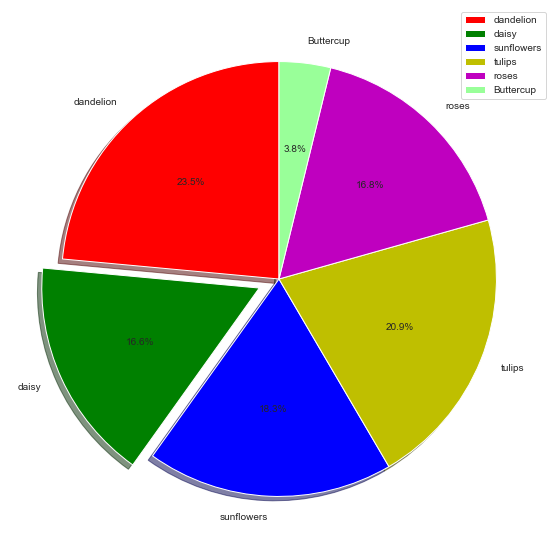

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.pie(list_species,labels=categories,startangle=90,colors=['r','g','b','y','m','#99ff99'],autopct='%1.1f%%',explode = (0, 0.1, 0, 0,0,0),shadow=True)
plt.legend()
plt.show()

In [11]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(y)

**Train Test split**

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12)

In [13]:
print("Shape of x_train", x_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_test", y_test.shape)

Shape of x_train (3052, 150, 150, 3)
Shape of y_train (3052, 6)
Shape of x_test (764, 150, 150, 3)
Shape of y_test (764, 6)


**CNN Model**

In [14]:
def cnn_model(input_shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(input_shape)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2, padding="same"))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2, padding="same"))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2, padding="same"))
  model.add(Dropout(0.2))
  
  model.add(Flatten())
  
  model.add(Dense(512, activation="relu"))
  
  model.add(Dropout(0.2))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation="softmax"))

  model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  
  return model

**Augmentation to avoid overfitting**

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

**Callbacks**

In [16]:
keras.backend.clear_session()
#callback function for early stopping

accuracy_threshold = 0.99999

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>99.99):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()

checkpoint_path = 'F:\\Ml files\\Weed detection\\flower recognition\\model\\kfold-cnn.h5'
epochs=50

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    acc_callback
]

In [17]:
#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    input_shape = 150,150,3
    model = cnn_model(input_shape)
    results = model.fit_generator(datagen.flow(t_x, t_y, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (val_x,val_y),
                              callbacks= callbacks,
                              verbose = 1, steps_per_epoch= t_x.shape[0] // 128)
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [18]:
n_folds=5
epochs = 50
batch_size = 128

model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1


C:\Users\Ovi\anaconda3\envs\tensrgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
21/21 [==============================] - 22s 791ms/step - loss: 2.1737 - accuracy: 0.1757 - val_loss: 1.7135 - val_accuracy: 0.2582

Epoch 00001: val_loss improved from inf to 1.71352, saving model to F:\Ml files\Weed detection\flower recognition\model\kfold-cnn.h5
Epoch 2/50
21/21 [==============================] - 13s 593ms/step - loss: 1.6607 - accuracy: 0.2807 - val_loss: 1.5353 - val_accuracy: 0.3595

Epoch 00002: val_loss improved from 1.71352 to 1.53526, saving model to F:\Ml files\Weed detection\flower recognition\model\kfold-cnn.h5
Epoch 3/50
21/21 [==============================] - 12s 581ms/step - loss: 1.4704 - accuracy: 0.3793 - val_loss: 1.3522 - val_accuracy: 0.4379

Epoch 00003: val_loss improved from 1.53526 to 1.35216, saving model to F:\Ml files\Weed detection\flower recognition\model\kfold-cnn.h5
Epoch 4/50
21/21 [==============================] - 12s 582ms/step - loss: 1.3043 - accuracy: 0.4537 - val_loss: 1.2413 - val_accuracy: 0.5261

Epoch 00004: val_

21/21 [==============================] - 13s 592ms/step - loss: 0.8003 - accuracy: 0.7035 - val_loss: 0.7894 - val_accuracy: 0.7092

Epoch 00022: val_loss did not improve from 0.52437
Epoch 23/50
21/21 [==============================] - 13s 591ms/step - loss: 0.7826 - accuracy: 0.7034 - val_loss: 0.7695 - val_accuracy: 0.7026

Epoch 00023: val_loss did not improve from 0.52437
Epoch 24/50
21/21 [==============================] - 13s 586ms/step - loss: 0.7937 - accuracy: 0.6940 - val_loss: 0.8014 - val_accuracy: 0.6961

Epoch 00024: val_loss did not improve from 0.52437
Epoch 25/50
21/21 [==============================] - 12s 582ms/step - loss: 0.7886 - accuracy: 0.7027 - val_loss: 0.7214 - val_accuracy: 0.7386

Epoch 00025: val_loss did not improve from 0.52437
Epoch 26/50
21/21 [==============================] - 12s 579ms/step - loss: 0.7629 - accuracy: 0.7107 - val_loss: 0.7615 - val_accuracy: 0.7190

Epoch 00026: val_loss did not improve from 0.52437
Epoch 27/50
21/21 [=============

21/21 [==============================] - 12s 578ms/step - loss: 1.6414 - accuracy: 0.2764 - val_loss: 1.4714 - val_accuracy: 0.3856

Epoch 00002: val_loss did not improve from 0.52437
Epoch 3/50
21/21 [==============================] - 12s 575ms/step - loss: 1.4084 - accuracy: 0.4040 - val_loss: 1.3608 - val_accuracy: 0.4510

Epoch 00003: val_loss did not improve from 0.52437
Epoch 4/50
21/21 [==============================] - 13s 589ms/step - loss: 1.3068 - accuracy: 0.4669 - val_loss: 1.2764 - val_accuracy: 0.4771

Epoch 00004: val_loss did not improve from 0.52437
Epoch 5/50
21/21 [==============================] - 12s 572ms/step - loss: 1.2393 - accuracy: 0.4769 - val_loss: 1.2579 - val_accuracy: 0.5229

Epoch 00005: val_loss did not improve from 0.52437
Epoch 6/50
21/21 [==============================] - 13s 586ms/step - loss: 1.2005 - accuracy: 0.5147 - val_loss: 1.1653 - val_accuracy: 0.5719

Epoch 00006: val_loss did not improve from 0.52437
Epoch 7/50
21/21 [==================

21/21 [==============================] - 13s 596ms/step - loss: 0.6635 - accuracy: 0.7550 - val_loss: 0.7206 - val_accuracy: 0.7288

Epoch 00033: val_loss did not improve from 0.52437
Epoch 34/50
21/21 [==============================] - 13s 607ms/step - loss: 0.6530 - accuracy: 0.7590 - val_loss: 0.7268 - val_accuracy: 0.7288

Epoch 00034: val_loss did not improve from 0.52437
Epoch 35/50
21/21 [==============================] - 13s 588ms/step - loss: 0.6521 - accuracy: 0.7566 - val_loss: 0.7269 - val_accuracy: 0.7353

Epoch 00035: val_loss did not improve from 0.52437
Epoch 36/50
21/21 [==============================] - 13s 586ms/step - loss: 0.6091 - accuracy: 0.7736 - val_loss: 0.7224 - val_accuracy: 0.7418

Epoch 00036: val_loss did not improve from 0.52437
Epoch 37/50
21/21 [==============================] - 13s 598ms/step - loss: 0.6127 - accuracy: 0.7737 - val_loss: 0.7075 - val_accuracy: 0.7516

Epoch 00037: val_loss did not improve from 0.52437
Epoch 38/50
21/21 [=============

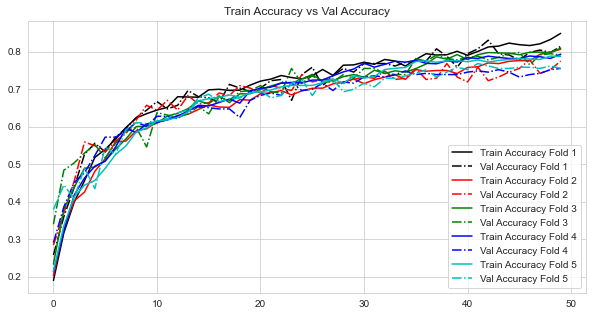

In [24]:
plt.figure(figsize=(10, 5))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='c', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

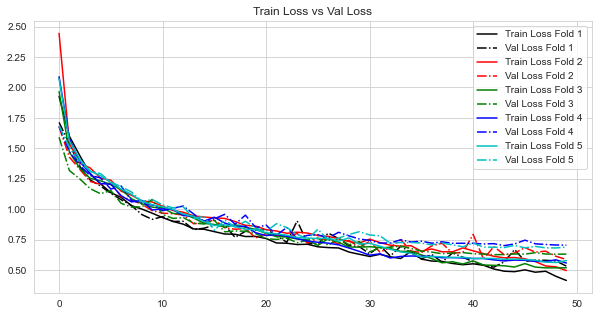

In [25]:
plt.figure(figsize=(10, 5))
plt.title('Train Loss vs Val Loss')
plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='c', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

In [30]:
#Load the model that was saved by ModelCheckpoint
nFoldCnnModel = load_model('F:\\Ml files\\Weed detection\\flower recognition\\model\\kfold-cnn.h5')
preds=nFoldCnnModel.predict(x_test)
predictions=np.argmax(preds,axis=1)

In [31]:
from sklearn.metrics import classification_report
Y_test =np.argmax(y_test,axis=1)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       181
           1       0.87      0.73      0.79       119
           2       0.79      0.91      0.85       138
           3       0.85      0.58      0.69       159
           4       0.68      0.82      0.74       146
           5       0.70      0.90      0.79        21

    accuracy                           0.78       764
   macro avg       0.78      0.80      0.78       764
weighted avg       0.79      0.78      0.78       764



In [34]:
def report_generate(Y_test, predictions):
  report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predictions, output_dict=True)).transpose()
  report = report.rename(index={'0': 'dandelion','1':'daisy','2':'sunflowers','3':'tulips', '4':'roses', '5':'Buttercup'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  
  plot=plt.tick_params(rotation=40)
  
  return plot,report

(None,
               precision  recall  f1-score
 dandelion         79.08   85.64     82.23
 daisy             87.00   73.11     79.45
 sunflowers        79.25   91.30     84.85
 tulips            85.19   57.86     68.91
 roses             68.39   81.51     74.37
 Buttercup         70.37   90.48     79.17
 accuracy          78.27   78.27     78.27
 macro avg         78.21   79.98     78.16
 weighted avg      79.33   78.27     77.91)

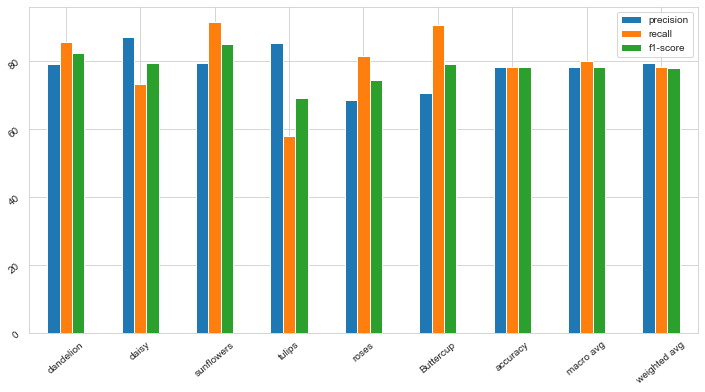

In [35]:
report_generate(Y_test, predictions)

In [36]:
#confusion matrix
def conf_matrix(Y_test, y_pred):

  cm = confusion_matrix(Y_test, y_pred) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['dandelion', 'daisy', 'sunflowers', 'tulips', 'roses', 'Buttercup'], 
                       columns = ['dandelion', 'daisy', 'sunflowers', 'tulips', 'roses','Buttercup'])
  plt.figure(figsize=(10,7))
  sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  plt.show()
  plt.close()

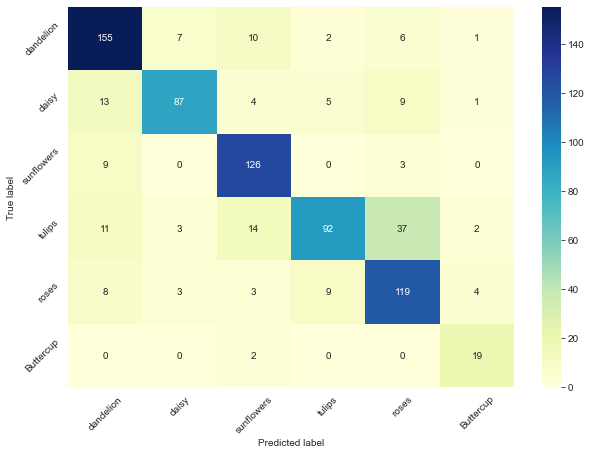

In [37]:
conf_matrix(Y_test,predictions)

ROC AUC score: 0.8774607881146744


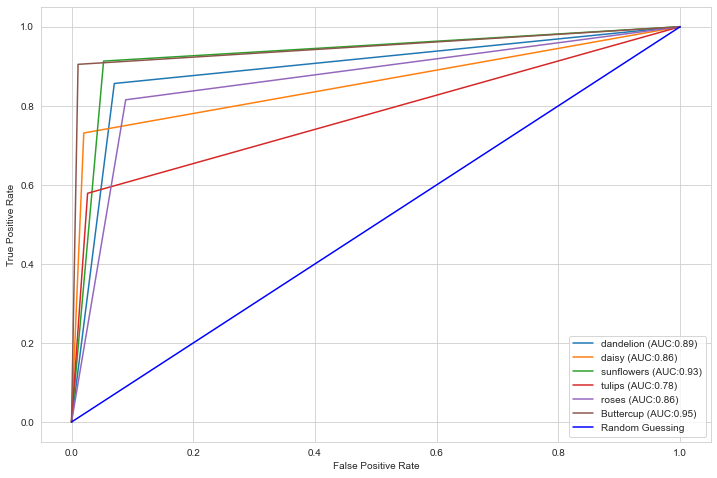

In [38]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test,predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


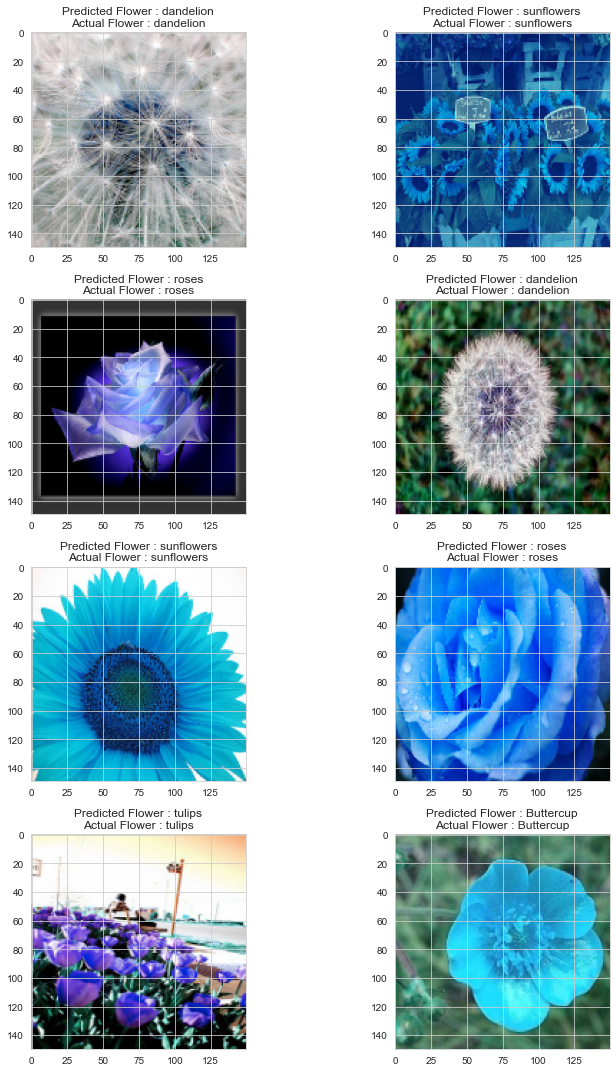

In [39]:
correct_class=[]
incorrect_class=[]
i=0
for i in range(len(y_test)):
    if(np.argmax(y_test[i])==predictions[i]):
        correct_class.append(i)
    if(len(correct_class)==8):
        break

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[correct_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[predictions[correct_class[count]]] +"\n"+"Actual Flower : "+ categories[np.argmax(y_test[correct_class[count]])])
        plt.tight_layout()
        count+=1

In [40]:
i=0
for i in range(len(y_test)):
    
    if (np.argmax(y_test[i])!=predictions[i]):
        
        incorrect_class.append(i)
    if (len(incorrect_class)==8):
        break


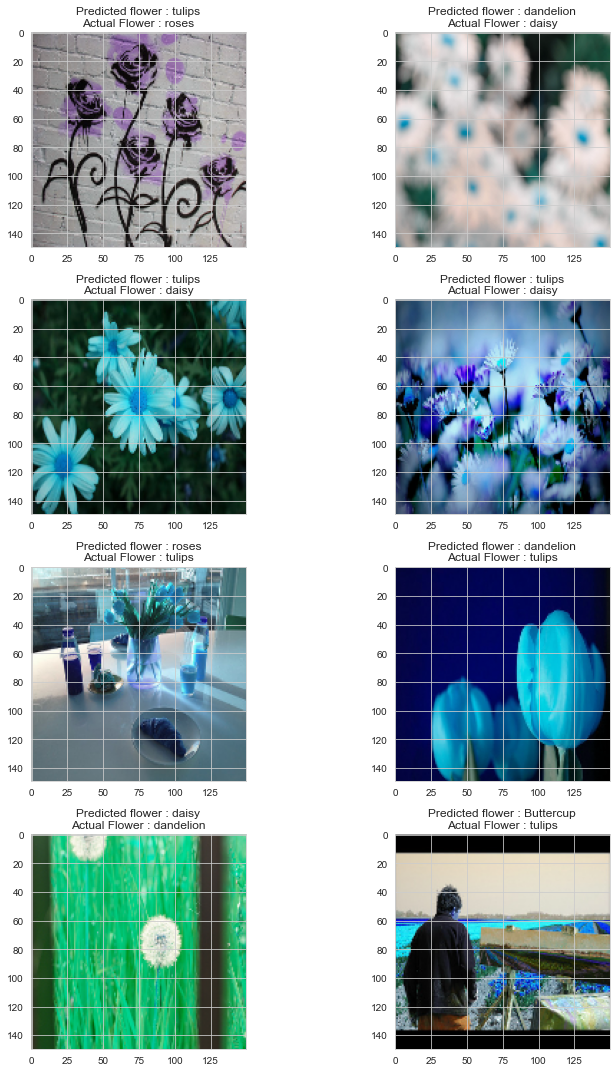

In [41]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range(2):
        ax[i,j].imshow(x_test[incorrect_class[count]])
        ax[i,j].set_title("Predicted flower : " + categories[predictions[incorrect_class[count]]] + "\n"+"Actual Flower : " +categories[np.argmax(y_test[incorrect_class[count]])])
        plt.tight_layout()
        count+=1

In [44]:
import requests
from PIL import Image
from io import BytesIO

def process_image(url):
    response=requests.get(url)
    img=Image.open(BytesIO(response.content))
    fix,ax=plt.subplots(1,3,figsize=(15,20))
    ax[0].imshow(img)
    ax[0].set_title('image')
    
    #grayscale and normalization
    img=np.array(img)
    img=cv2.cvtColor(img,cv2.IMREAD_COLOR)
    print(img.shape)
    img=img/255.0
    ax[1].imshow(img)
    ax[1].set_title('color image')
    
    #resizing
    img=cv2.resize(img,(150,150))
    print(img.shape)
    ax[2].imshow(img)
    ax[2].set_title('predicted image')
    plt.tight_layout()
    img=np.expand_dims(img,axis=0)
    #making it model ready
    
    print(img.shape)
    return img


    
def predict(url):
    img=process_image(url)
    label=nFoldCnnModel.predict(img)
    final_1=np.argmax(label,axis=1)[0]
    plt.xlabel(categories[final_1])
    return categories[final_1]


(900, 600, 3)
(150, 150, 3)
(1, 150, 150, 3)


'tulips'

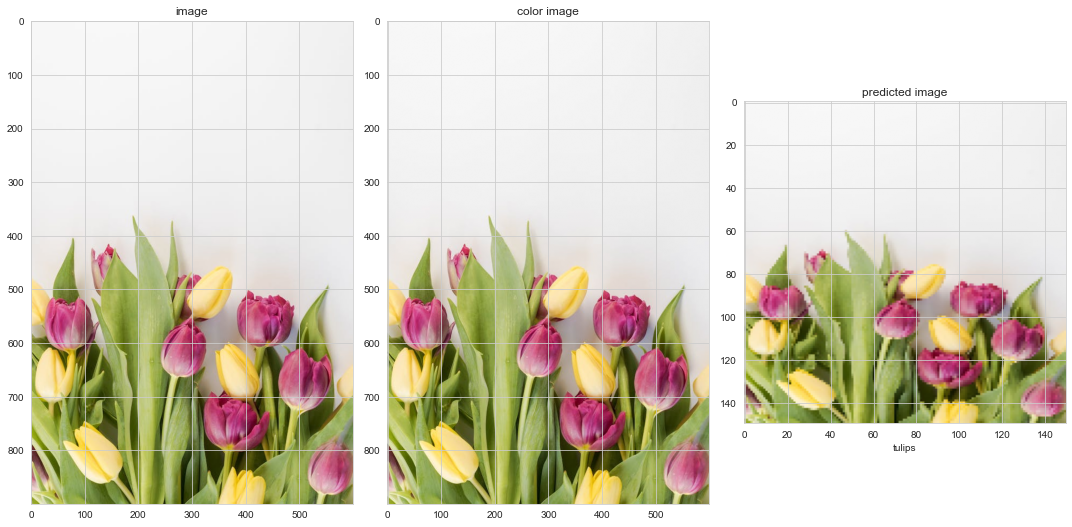

In [45]:
predict("https://images.pexels.com/photos/1883385/pexels-photo-1883385.jpeg?auto=compress&cs=tinysrgb&w=600")